In [ ]:
!pip3 install torch
!pip3 install torchvision

In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
BATCH_SIZE = 32
GDRIVE_PATH = '/content/drive/MyDrive'
PROJ_PATH = os.path.join(GDRIVE_PATH, 'Colab Notebooks/PyTorch')
DATA_PATH = os.path.join(PROJ_PATH, 'data')
MODEL_ROOT_PATH = os.path.join(PROJ_PATH, 'model')

In [ ]:
## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root=DATA_PATH, train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root=DATA_PATH, train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
model = nn.Sequential(
          nn.Conv2d(1,32,3),
          nn.LeakyReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(32,64,3),
          nn.LeakyReLU(),
          nn.MaxPool2d(2),
          nn.Flatten(),
          nn.Linear(1600, 128),
          nn.LeakyReLU(),
          nn.Linear(128, 64),
          nn.LeakyReLU(),
          nn.Linear(64, 10),
          nn.Softmax(dim=1)
        )

Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Model output dimensions: torch.Size([32, 10])
tensor([9, 5, 2, 7, 5, 4, 9, 5, 1, 6, 0, 0, 3, 2, 2, 1, 4, 1, 1, 4, 7, 3, 1, 9,
        1, 6, 8, 7, 3, 4, 8, 1])


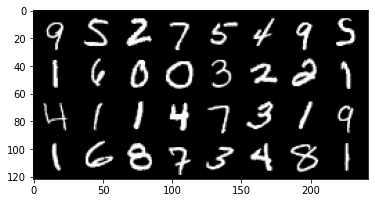

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image label dimensions:", labels.shape)
print("Image batch dimensions:", images.shape)

out = model(images)
print("Model output dimensions:", out.shape)

## show images
print(labels)
imshow(torchvision.utils.make_grid(images))

In [ ]:
MODEL_LOAD_PATH = os.path.join(MODEL_ROOT_PATH, 'number_classification_10')
model.load_state_dict(torch.load(MODEL_LOAD_PATH))

In [ ]:
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
MODEL_SAVE_PATH = os.path.join(MODEL_ROOT_PATH, 'number_classification_10')

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

torch.save(model.state_dict(), MODEL_SAVE_PATH)

Epoch: 0 | Loss: 1.5546 | Train Accuracy: 91.05
Epoch: 1 | Loss: 1.4879 | Train Accuracy: 97.51
Epoch: 2 | Loss: 1.4823 | Train Accuracy: 98.06
Epoch: 3 | Loss: 1.4782 | Train Accuracy: 98.44
Epoch: 4 | Loss: 1.4771 | Train Accuracy: 98.54
Epoch: 5 | Loss: 1.4770 | Train Accuracy: 98.55
Epoch: 6 | Loss: 1.4757 | Train Accuracy: 98.67
Epoch: 7 | Loss: 1.4747 | Train Accuracy: 98.78
Epoch: 8 | Loss: 1.4749 | Train Accuracy: 98.76
Epoch: 9 | Loss: 1.4742 | Train Accuracy: 98.83


In [ ]:
testdataiter = iter(testloader)

Model output vs Image label
tensor([8, 3, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 5, 3, 3, 9, 7, 8, 6, 3, 6, 1, 3,
        8, 1, 0, 5, 1, 3, 1, 5])
tensor([9, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 5, 3, 3, 9, 7, 8, 6, 5, 6, 1, 3,
        8, 1, 0, 5, 1, 3, 1, 5])
Accuracy: 90.625


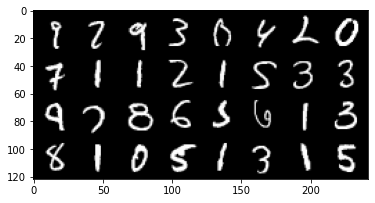

In [ ]:
testimages, testlabels = testdataiter.next()

logits = model(testimages)
output = torch.max(logits, 1)[1].view(testlabels.size())
print("Model output vs Image label")
print(output)
print(testlabels)
print("Accuracy:", get_accuracy(logits, testlabels, BATCH_SIZE))
imshow(torchvision.utils.make_grid(testimages))